# Initialisation

Loading pre-requisite libraries

In [ ]:
import numpy as np
import pandas as pd 
import os
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import PIL
import datetime
from io import BytesIO
from urllib import request

Loading Gdrive data pipeline

In [ ]:
import csv
from google.colab import drive
drive.mount('/content/gdrive')
!ls gdrive/Shareddrives/CIS519/'CIS 519 Project'/Data/

Mounted at /content/gdrive
'AK Temp'	     'Genre readme.gdoc'	   'Raw Data'
 books_clean.csv.gz   OLD_books_with_genre.csv.gz
 Covers		     'Preprocessing 2.ipynb'


Library configurations

In [ ]:
pd.options.display.max_colwidth = 100

Loading dataset

In [ ]:
df = pd.read_csv('gdrive/Shareddrives/CIS519/CIS 519 Project/Data/books_clean.csv.gz')

# Preparing the Dataset

For processing of the pre-cleaned dataset for analysis and training of book covers specifically.

In [ ]:
df.head(3)

,Unnamed: 0,isbn,average_rating,description,link,authors,publisher,num_pages,isbn13,publication_year,image_url,book_id,title,title_without_series,first,second,third,genre_cleaned,genre_cleaned2,genre_cleaned3
0,0,0312853122,4.00,NaN,https://www.goodreads.com/book/show/5333265-w-c-fields,604031.0,St. Martin's Press,256.0,9780312853129,1984.0,https://images.gr-assets.com/books/1310220028m/5333265.jpg,5333265,W.C. Fields: A Life on Film,W.C. Fields: A Life on Film,"history, historical fiction, biography",NaN,NaN,"history, historical fiction, biography","history, historical fiction, biography","history, historical fiction, biography"
1,1,0743509986,3.23,"Anita Diamant's international bestseller ""The Red Tent"" brilliantly re-created the ancient world...",https://www.goodreads.com/book/show/1333909.Good_Harbor,626222.0,Simon & Schuster Audio,NaN,9780743509985,2001.0,NaN,1333909,Good Harbor,Good Harbor,fiction,"history, historical fiction, biography",NaN,"history, historical fiction, biography","fiction: history, historical fiction, biography","fiction: history, historical fiction, biography"
2,2,NaN,4.03,Omnibus book club edition containing the Ladies of Madrigyn and the Witches of Wenshar.,https://www.goodreads.com/book/show/7327624-the-unschooled-wizard,10333.0,"Nelson Doubleday, Inc.",600.0,NaN,1987.0,https://images.gr-assets.com/books/1304100136m/7327624.jpg,7327624,"The Unschooled Wizard (Sun Wolf and Starhawk, #1-2)","The Unschooled Wizard (Sun Wolf and Starhawk, #1-2)","fantasy, paranormal",fiction,"mystery, thriller, crime","fantasy, paranormal","fantasy, paranormal","fiction: fantasy, paranormal"


The dataset contains the columns: genre_cleaned, genre_cleaned2, and genre_cleaned3. These represent three variations of corrections made to the genres for each book. 

After preliminary data analysis, we have found genre_cleaned to the best correction method to use for our purposes.

In order to build a classification model for cover image classification, we must understand the dataset better within this context. Consequently, we must prepare the data by dropping irrelevant columns and removes rows where no images are present.

In [ ]:
covers_df = df.drop(["isbn", "average_rating", "description", "link", "authors", "publisher", "num_pages", "isbn13", "publication_year", "title", "title_without_series", "Unnamed: 0", "first", "second", "third", "genre_cleaned2", "genre_cleaned3"], axis = "columns").dropna().reset_index(drop = True)

In [ ]:
covers_df.head(3)

,image_url,book_id,genre_cleaned
0,https://images.gr-assets.com/books/1310220028m/5333265.jpg,5333265,"history, historical fiction, biography"
1,https://images.gr-assets.com/books/1304100136m/7327624.jpg,7327624,"fantasy, paranormal"
2,https://images.gr-assets.com/books/1413219371m/287140.jpg,287140,non-fiction


In order for genre_cleaned to be used suitably as labels, they must first be ordinally encoded:

In [ ]:
ENCODING_TO_LABELS = {0: "history, historical fiction, biography",
                        1: "fantasy, paranormal",
                        2: "romance",
                        3: "non-fiction",
                        4: "fiction",
                        5: "mystery, thriller, crime",
                        6: "children",
                        7: "young-adult",
                        8: "poetry",
                        9: "comics, graphic"}

LABELS_TO_ENCODING = {"history, historical fiction, biography": 0,
                        "fantasy, paranormal": 1,
                        "romance": 2,
                        "non-fiction": 3,
                        "fiction": 4,
                        "mystery, thriller, crime": 5,
                        "children": 6,
                        "young-adult": 7,
                        "poetry": 8,
                        "comics, graphic": 9}

In [ ]:
covers_df['genre_ordinal'] = covers_df['genre_cleaned'].map(LABELS_TO_ENCODING)

In [ ]:
covers_df.head

<bound method NDFrame.head of                                                           image_url   book_id  \
0        https://images.gr-assets.com/books/1310220028m/5333265.jpg   5333265   
1        https://images.gr-assets.com/books/1304100136m/7327624.jpg   7327624   
2         https://images.gr-assets.com/books/1413219371m/287140.jpg    287140   
3        https://images.gr-assets.com/books/1316637798m/6066812.jpg   6066812   
4       https://images.gr-assets.com/books/1493525974m/34883016.jpg  34883016   
...                                                             ...       ...   
806156  https://images.gr-assets.com/books/1358292922m/17252880.jpg  17252880   
806157  https://images.gr-assets.com/books/1372041556m/17993003.jpg  17993003   
806158    https://images.gr-assets.com/books/1505318849m/259397.jpg    259397   
806159  https://images.gr-assets.com/books/1344707483m/12724326.jpg  12724326   
806160  https://images.gr-assets.com/books/1397766678m/17557627.jpg  17557627  

# A Look into the Covers

Let us try loading one image first by accessing the link for the first book in the dataset:

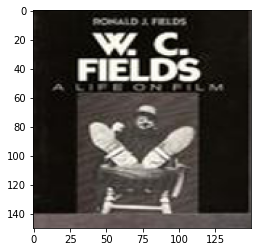

In [ ]:
# Try loading one image
url = covers_df["image_url"][0]
res = request.urlopen(url).read()
Sample_Image = PIL.Image.open(BytesIO(res)).resize((150,150))

plt.imshow(Sample_Image)

In order to transform these images into a format suitable for training, we will convert them into numpy arrays.

However, in conducting EDA on the cover images, it is discovered that the images vary in dimensions, and the number of channels - some images have two, and others have four! 

Meanwhile some links are completely broken. Fortunately, these instances only occur in about 1% of the dataset.

A way to get around these situations is to standardise the image sizes to (224, 224, 3), while broken links and other anomalous sitations will simply be replaced with an empty array.

In [ ]:
def load_image(url):
    try:
      if request.urlopen(url).getcode() == 200:
        img = PIL.Image.open(BytesIO(request.urlopen(url).read())).resize((224,224))
        img = tf.keras.utils.img_to_array(img)
        if img.shape[2] > 3 or img.shape[2] < 3:
          img = np.zeros([224, 224, 3])
      else:
        img = np.zeros([224, 224, 3])
    except:
      img = np.zeros([224, 224, 3])
    return img

In [ ]:
load_image(covers_df["image_url"][0])

array([[[ 30.,  27.,  22.],
        [ 29.,  26.,  21.],
        [ 27.,  24.,  19.],
        ...,
        [ 42.,  37.,  33.],
        [ 58.,  53.,  49.],
        [ 63.,  58.,  54.]],

       [[ 30.,  27.,  22.],
        [ 29.,  26.,  21.],
        [ 27.,  24.,  19.],
        ...,
        [ 38.,  33.,  29.],
        [ 54.,  49.,  45.],
        [ 61.,  56.,  52.]],

       [[ 30.,  27.,  22.],
        [ 30.,  27.,  22.],
        [ 27.,  24.,  19.],
        ...,
        [ 34.,  29.,  25.],
        [ 50.,  45.,  41.],
        [ 57.,  52.,  48.]],

       ...,

       [[111.,  97.,  96.],
        [111.,  97.,  96.],
        [110.,  96.,  95.],
        ...,
        [ 84.,  79.,  76.],
        [ 83.,  78.,  75.],
        [ 83.,  78.,  75.]],

       [[111.,  97.,  96.],
        [111.,  97.,  96.],
        [110.,  96.,  95.],
        ...,
        [ 81.,  76.,  73.],
        [ 80.,  75.,  72.],
        [ 80.,  75.,  72.]],

       [[111.,  97.,  96.],
        [111.,  97.,  96.],
        [110.,  

Let's test this function by loading the first 25 images!

In [ ]:
def plot_images(images,labels):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)    
        plt.xlabel(ENCODING_TO_LABELS[labels[i]])
    plt.show()

In [ ]:
images = [load_image(covers_df["image_url"][i])/255.0 for i in range(25)]

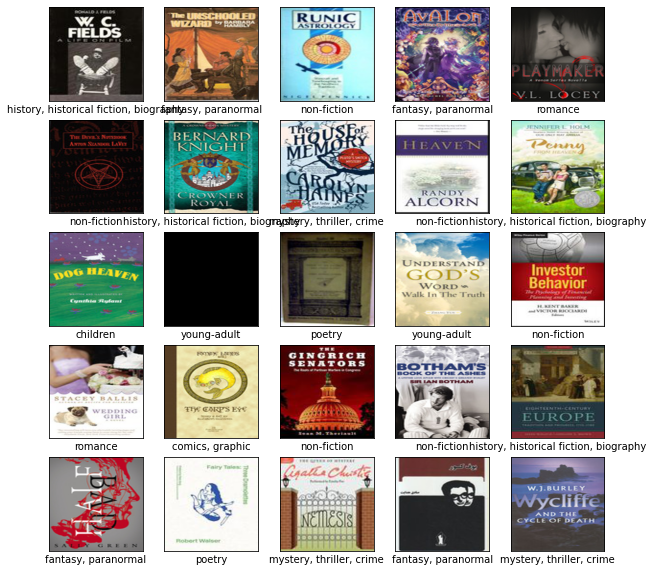

In [ ]:
plot_images(images,covers_df.head(25)["genre_ordinal"])

At first glance at the book covers available to us, we can anticipate that the classification model may have trouble predicting images whose genres are "poetry", "fiction", and "young adult". This is due to not only the style of the covers themselves, but also the the frequency in which they occur in the dataset.

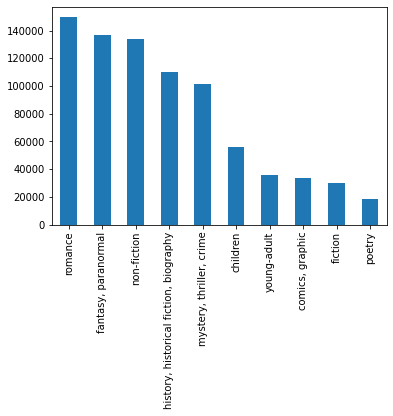

In [ ]:
fig, ax = plt.subplots()
covers_df['genre_cleaned'].value_counts().plot(ax=ax, kind='bar')

We anticipate that despite the low frequency of "comics, graphic" and "children" that the model will still perform well on these genres due to the their distinctive stylistic differences from the other genres.

# Downloading the Covers

Due to the size of the dataset (806,161 images), and the limitations of the HTTP call requests we may have in any given instance, we will need to save these images "locally" in batches:

In [ ]:
# Load images by batches to avoid HTTP exceptions:
start_val = 0
end_val = 806000
difference = 1000

for j in range(start_val, end_val, difference):
  print("Starting " + str(j))
  images = np.array([load_image(covers_df["image_url"][i]) for i in range(j,j+difference)])
  labels = covers_df["genre_ordinal"].to_numpy()[j:j+difference]
  np.savez_compressed("gdrive/Shareddrives/CIS519/CIS 519 Project/Data/Covers/" + str(j) + "-images-labels", images = images, labels = labels)
  print("Ending " + str(j))

Each compressed .npz file is approximately 150 mb large. The entire dataset if downloaded would be about 120.9 gb large. Consequently, we will be unlikely to be able to access the entire dataset of images.

In [ ]:
!ls gdrive/Shareddrives/CIS519/'CIS 519 Project'/Data/Covers

 0-images-labels.npz	    2000-labels.npz	       307000-images-labels.npz
 0-labels.npz		    201000-images-labels.npz   308000-images-labels.npz
 100000-images-labels.npz   202000-images-labels.npz   309000-images-labels.npz
 10000-images-labels.npz    203000-images-labels.npz   310000-images-labels.npz
 10000-labels.npz	    204000-images-labels.npz   31000-images-labels.npz
 1000-images-labels.npz     205000-images-labels.npz   31000-labels.npz
 1000-labels.npz	    206000-images-labels.npz   311000-images-labels.npz
 100-images-labels.npz	    207000-images-labels.npz   312000-images-labels.npz
 101000-images-labels.npz   208000-images-labels.npz   313000-images-labels.npz
 102000-images-labels.npz   209000-images-labels.npz   314000-images-labels.npz
 103000-images-labels.npz   210000-images-labels.npz   315000-images-labels.npz
 104000-images-labels.npz   21000-images-labels.npz    316000-images-labels.npz
 105000-images-labels.npz   21000-labels.npz	       317000-images-labels.npz
 1

# Modelling

We will be building upon pre-trained models for our given task. Keras provides a number of pre-trained models that can be trained upon further to produce produce genre classifications for the covers dataset.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical

In [ ]:
# Load VGG16

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False # Not trainable weights

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Having loaded in the pre-trained model, VGG16 in this case, we can add additional layers to train for our given classifiers.

In [ ]:
# Add our last layers
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(2, activation='relu')
dense_layer_2 = layers.Dense(3, activation='relu')
prediction_layer = layers.Dense(10, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 2)                 50178     
                                                                 
 dense_1 (Dense)             (None, 3)                 9         
                                                                 
 dense_2 (Dense)             (None, 10)                40        
                                                                 
Total params: 14,764,915
Trainable params: 50,227
Non-trainable params: 14,714,688
_________________________________________________________________


## Building a Training Loop from Scratch

Due to how our images have been saved in .npz batches, we must build a custom training loop to access the data. Otherwise loading the entire dataset for each epoch would take too much memory.

In [ ]:
# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)

# Instantiate a loss function.
loss_fn = tf.keras.losses.CategoricalCrossentropy()

In [ ]:
# Prepare the metrics.
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
val_acc_metric = tf.keras.metrics.CategoricalAccuracy()

In [ ]:
@tf.function
def train_step(x, y): # This is the function that does the actual training 
    with tf.GradientTape() as tape:
        logits = model(x, training = True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    return loss_value

In [ ]:
@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
    val_acc_metric.update_state(y, val_logits)

In [ ]:
import time

batch_size = 100 #Loads iamges in micro-batches
epochs = 10

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()
    for i in range(0, 100000, 1000):
      print(str(i) + " to " + str(i+1000))
      with np.load("gdrive/Shareddrives/CIS519/CIS 519 Project/Data/Covers/" + str(i) + "-images-labels.npz", allow_pickle = True) as images_labels: # temp load file
        images = fix_type(images_labels["images"]) # stores images
        labels = images_labels["labels"] # stores labels

      # Iterate over the batches of the dataset.
      train_labels = to_categorical(labels, num_classes = 10)
      train_dataset = tf.data.Dataset.from_tensor_slices((images, train_labels)).batch(100)

      for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
          loss_value = train_step(x_batch_train, y_batch_train)

          # Log every 200 images
          if step % 2 == 0:
              print(
                  "Training loss (for one batch) at step %d: %.4f"
                  % (step, float(loss_value))
              )
              print("Seen so far: %d samples" % ((step + 1) * batch_size))

    # Save model at the end of each epoch
    model.save("/content/gdrive/Shareddrives/CIS519/CIS 519 Project/Models/Cover_Model/covers-model-v5", save_format="h5")

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for i in range(100000, 101000, 1000):
      with np.load("gdrive/Shareddrives/CIS519/CIS 519 Project/Data/Covers/" + str(i) + "-images-labels.npz", allow_pickle = True) as images_labels: # temp load file
        images = fix_type(images_labels["images"]) # stores images
        labels = images_labels["labels"] # stores labels
      
      val_labels = to_categorical(labels, num_classes = 10)
      val_dataset = tf.data.Dataset.from_tensor_slices((images, val_labels)).batch(100)

      for x_batch_val, y_batch_val in val_dataset:
          test_step(x_batch_val, y_batch_val)

    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))

The above code also saves the model per epoch.

Reference: https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch

## Loading in Trained Model

Having trained multiple models and variations of models, we can draw comparisons on their performance. In this instance, we load in VGG16 version 5:

In [ ]:
model = tf.keras.models.load_model(
    "/content/gdrive/Shareddrives/CIS519/CIS 519 Project/Models/Cover_Model/covers-model-v5", custom_objects=None, compile=True, options=None
)

In [ ]:
model.summary()

## Predicting Genres Across Images

We can now make predictions given a set of images and return test accuracy:

In [ ]:
def predict_images(range_of_values):
  error = np.zeros([0,])
  for i in range(range_of_values[0], range_of_values[1], 1000):
    print(i)
    with np.load("gdrive/Shareddrives/CIS519/CIS 519 Project/Data/Covers/" + str(i) + "-images-labels.npz", allow_pickle = True) as images_labels: # temp load file
      images = fix_type(images_labels["images"]) # stores images
      labels = images_labels["labels"] # stores labels
    prediction = model.predict(images)
    # print(prediction)
    predicted_classes = np.array([np.argmax(y, axis = None, out = None) for y in np.round(prediction)])
    error = np.append(error, np.mean(predicted_classes != labels))
  return np.mean(error)

For VGG16 v5, we attain a 67% test accuracy when predicting genres across 20,000 random images.

## Saving the Predictions

We want to produce predictions for the entire dataset that is available. Consequently we create a loop to automatically load in each batch, produce predictions, and append those predictions to the master list.

In [ ]:
predictions = np.load("gdrive/Shareddrives/CIS519/CIS 519 Project/Data/Covers/predictions.npz")["predictions"]

In [ ]:
# predictions = np.zeros([0,])
for i in range(predictions.shape[0], 320000, 1000):
  print(str(i) + " to " + str(i+1000))
  with np.load("gdrive/Shareddrives/CIS519/CIS 519 Project/Data/Covers/" + str(i) + "-images-labels.npz", allow_pickle = True) as images_labels: # temp load file
    images = fix_type(images_labels["images"]) # stores images
    labels = images_labels["labels"] # stores labels
  predicted = np.array([np.argmax(y, axis = None, out = None) for y in np.round(model.predict(images))])
  predictions = np.append(predictions, predicted)
  
  print(predictions.dtype, predictions.shape)
  np.savez_compressed("gdrive/Shareddrives/CIS519/CIS 519 Project/Data/Covers/predictions", predictions = predictions)
  

# VGG16 v5 Model Analysis

We analyse the results of the predictions generated by the model.

It should be remembered that VGG16 v5 was trained on 100,000 images across 7 epochs and tested against 20,000 images.

## Loading the Predictions
First we load in the predictions into the dataset and transform the labels into classes:

In [ ]:
predictions = np.load("gdrive/Shareddrives/CIS519/CIS 519 Project/Data/Covers/predictions.npz")["predictions"]

covers_df = pd.DataFrame(covers_df.head(len(predictions)))
covers_df["predictions"] = predictions
covers_df["predictions"] = covers_df["predictions"].map(ENCODING_TO_LABELS)
covers_df.filter(["book_id", "genre_cleaned", "predictions"])

,book_id,genre_cleaned,predictions
0,5333265,"history, historical fiction, biography","history, historical fiction, biography"
1,7327624,"fantasy, paranormal","fantasy, paranormal"
2,287140,non-fiction,non-fiction
3,6066812,"fantasy, paranormal","fantasy, paranormal"
4,34883016,romance,romance
...,...,...,...
314995,8417128,"mystery, thriller, crime","fantasy, paranormal"
314996,6764329,"history, historical fiction, biography","history, historical fiction, biography"
314997,6069946,young-adult,romance
314998,8417126,poetry,"fantasy, paranormal"


In [ ]:
genre_prediction_analysis = pd.DataFrame([covers_df[covers_df["genre_cleaned"] == covers_df["predictions"]].groupby("genre_cleaned").count()["image_url"], covers_df[covers_df["genre_cleaned"] != covers_df["predictions"]].groupby("genre_cleaned").count()["predictions"]])
genre_prediction_analysis.index = ["Correct", "Incorrect"]
genre_prediction_analysis = genre_prediction_analysis.T
genre_prediction_analysis

,Correct,Incorrect
genre_cleaned,,
children,13203,8622
"comics, graphic",6246,6972
"fantasy, paranormal",29066,24277
fiction,1955,9961
"history, historical fiction, biography",25349,17497
"mystery, thriller, crime",22666,17011
non-fiction,26108,26201
poetry,1878,5469
romance,34765,23805


Let's convert these into percentages to get an idea of the test accuracy regardless of their frequency and plot it into a graph:

In [ ]:
genre_prediction_percentage = genre_prediction_analysis
genre_prediction_percentage["Correct, %"] = genre_prediction_analysis["Correct"]/(genre_prediction_analysis["Correct"] + genre_prediction_analysis["Incorrect"])
genre_prediction_percentage["Incorrect, %"] = genre_prediction_analysis["Incorrect"]/(genre_prediction_analysis["Correct"] + genre_prediction_analysis["Incorrect"])
genre_prediction_percentage.filter(["Correct, %", "Incorrect, %"])

,"Correct, %","Incorrect, %"
genre_cleaned,,
children,0.604948,0.395052
"comics, graphic",0.472537,0.527463
"fantasy, paranormal",0.544889,0.455111
fiction,0.164065,0.835935
"history, historical fiction, biography",0.591630,0.408370
"mystery, thriller, crime",0.571263,0.428737
non-fiction,0.499111,0.500889
poetry,0.255615,0.744385
romance,0.593563,0.406437


Where "Correct, %" represents the test accuracy.

## What the Predictions Tell Us

We can visualise the prediction accuracy of each genre.

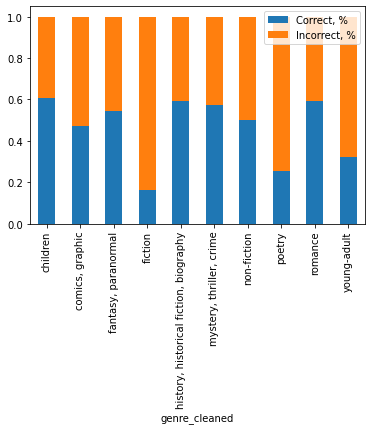

In [ ]:
ax = genre_prediction_analysis.filter(["Correct, %", "Incorrect, %"]).plot.bar(stacked=True)

We can utilise sklearn's classification report to give us a break down of the precision, recall, and f1-scores of each respective genre.

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(covers_df["genre_cleaned"], covers_df["predictions"]))

                                        precision    recall  f1-score   support

                              children       0.65      0.60      0.63     21825
                       comics, graphic       0.78      0.47      0.59     13218
                   fantasy, paranormal       0.57      0.54      0.56     53343
                               fiction       0.59      0.16      0.26     11916
history, historical fiction, biography       0.31      0.59      0.41     42846
              mystery, thriller, crime       0.47      0.57      0.52     39677
                           non-fiction       0.64      0.50      0.56     52309
                                poetry       0.56      0.26      0.35      7347
                               romance       0.71      0.59      0.65     58570
                           young-adult       0.40      0.32      0.36     13949

                              accuracy                           0.53    315000
                             macro avg

From this we can see that the genre "history, historical fiction, biography" has the lowest precision among the other genres. This is likely due to an error in how the predicted results are being translated into labels, where inconclusive predictions are returned as "history, historical fiction, biography" which is indexed as "0".

The genres "fiction", "poetry", and "young-adult" perform the worst on this model. This is aligns well with out initial hypothesis as they represent the genres whose covers are both hard to disambiguate visually but also occur the least in the dataset.

The genres "children" and "comics, graphic" perform relatively well despite their low frequencies in the dataset, which also aligns with our initial hypothesis as they have very distinctive cover styles.

Hypothetically, these predictions would supplement areas of poor performance in book titles and book descriptions. For example, "children" and "romance" performed poorly in genre predictions through titles, while these were the best performing genres for predictions from book covers. Consequently, we can see how ensemble could drastically improve our ability to make genre predictions given title, descriptions, and book covers.